## Import Required Libraries

In [258]:
import pandas as pd
import numpy as np
import mat73
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from pymultitaper import multitaper_spectrogram, plot_spectrogram

## Data Reading and PreProcessing

In [259]:
# Load .mat file
data = mat73.loadmat('./lfpUCLAC.mat')["lfpUCLAC"]
#data = mat73.loadmat('lfpUCLAC.mat')["lfpUCLAC"]
# Turn seizure data into a DataFrame
data = np.concatenate((data[:, :2], data[:, 11:]), axis=1)
column_names = ["Animal", "Session"]
column_names += [f"SZ_{i}" for i in range(11, 36012)]
seizure = pd.DataFrame(data, columns=column_names)
# Read Meta Data
#metadata = pd.read_csv("ADszNov7v21LeoIv2(in).csv")
metadata = pd.read_csv("./ADszNov7v21LeoIv3.csv")
# Merge two DataFrames
dataset = pd.merge(metadata, seizure, on=["Animal", "Session"], how='inner')

In [260]:
dataset

,Animal,Session,group,BaseStart,BaseEnd,NoSzstart2,NoSzend2,SzArtifactStart,SzArtifactEnd,SeizureStart,...,SZ_36002,SZ_36003,SZ_36004,SZ_36005,SZ_36006,SZ_36007,SZ_36008,SZ_36009,SZ_36010,SZ_36011
0,8790,2,1,-60.0,-20.0,6.0,120,-21.00,0,3.3,...,0.895588,0.866927,1.000345,1.083360,1.033944,0.890641,0.746350,0.860990,0.699898,0.401434
1,8799,2,1,-60.0,-11.0,30.0,120,-12.00,0,20.5,...,0.128512,0.141584,0.138678,0.087841,0.079126,0.025384,0.067505,-0.051598,0.006501,0.070409
2,12224,2,1,-60.0,-8.0,13.0,120,-7.50,0,8.5,...,0.009078,-0.023774,-0.006766,0.009076,-0.015155,-0.015389,0.014666,-0.004905,-0.014225,0.013500
3,12233,2,1,-60.0,-3.0,30.0,120,-2.00,0,10.0,...,0.001998,-0.022745,0.031218,-0.214643,0.020953,0.060175,-0.098818,0.052542,-0.026954,-0.019320
4,12234,2,1,-60.0,-2.0,39.0,120,-1.00,0,12.0,...,0.193024,-0.020621,0.196557,0.332058,0.345042,0.281896,0.317190,0.327150,0.339630,0.317448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,12233,19,1,0.0,0.0,20.0,89,0.65,0,9.2,...,0.016741,0.099218,-0.023653,0.102346,0.103549,-0.060198,0.098502,0.002803,-0.011623,0.046087
165,8793,19,2,-60.0,-37.0,28.5,120,0.00,0,2.6,...,-0.588621,-0.241770,0.429002,0.486332,0.377403,0.214010,0.007618,0.050616,-0.045414,0.133745
166,8797,19,2,-60.0,-53.0,40.0,120,0.00,0,3.3,...,0.074535,-0.049774,-0.050855,0.014002,0.137230,0.119934,0.122096,0.004272,0.018324,0.037781
167,12227,19,2,-60.0,-3.0,46.0,120,0.40,0,8.8,...,0.420122,0.379910,0.380465,0.387676,0.385735,0.359945,0.362996,0.341087,0.320843,0.318070


In [261]:
# Preprocessing lfp file
#sampling_rate
fs = 200


# Design the bandpass filter
b, a = butter(8, [4, 50], 
              btype='bandpass', fs=fs)

# Apply zero-phase filtering
rawlfp = dataset.loc[:, "SZ_11":]
rawlfp = rawlfp.to_numpy()

start = -60
stop = 120
# fast = filtfilt(b, a, lfp_f)

t_lfp = np.linspace(start, stop, rawlfp.shape[1]) 
t_base = np.where(t_lfp<=2)

lfp_f = rawlfp.copy()
# reduce amplitude of noise in raw lfp
for lfp_in in range(rawlfp.shape[0]): 
    
    # lfp_f[lfp_in,:] = rawlfp[lfp_in,:]
    lfp_f[lfp_in,:] = filtfilt(b, a, lfp_f[lfp_in,:])
    lfp_b = lfp_f[lfp_in,t_base]
    std_b = np.std(lfp_b)
    mean_b = np.mean(lfp_b)
    thresh_b = 3 * std_b
    mask_b = np.abs(lfp_b-mean_b) <= thresh_b
    lfp_b[~mask_b] = 0
    lfp_f[lfp_in,t_base] = lfp_b


fast = lfp_f.copy()


In [262]:
def zscorelfp_data(datalfp):
    datapsd = zscore(datalfp, axis=None)
    min_lfp = np.min(datalfp)
    max_lfp = np.max(datalfp)
    datalfpnorm = datalfp - min_lfp / (max_lfp - min_lfp) * 10
    return datalfpnorm

In [263]:
# Parameters
fs = 200




In [264]:
import math
def time2index(time, start, WindowStep):
    return math.floor((time - start) / WindowStep)

In [265]:
print(dataset[times_to_convert[0]])

0     -60.0
1     -60.0
2     -60.0
3     -60.0
4     -60.0
       ... 
164     0.0
165   -60.0
166   -60.0
167   -60.0
168     0.0
Name: BaseStart, Length: 169, dtype: float64


In [266]:
start = -60

lfpwindowstep = 1/fs

times_to_convert = ["BaseStart", "BaseEnd","SeizureStart", "SeizureEnd", "SzArtifactStart", "SzArtifactEnd"]
for column_name in times_to_convert:
    dataset[column_name] = dataset[column_name].apply(lambda x: time2index(x, start=start, WindowStep=lfpwindowstep))
    #dataset[column_name] = dataset[column_name].astype(int)

In [267]:
duration_epoch = 0.5
samples_per_epoch = int(fs*duration_epoch)
dataEpochs = ["BaseStart", "BaseEnd","SeizureStart", "SeizureEnd", "SzArtifactStart", "SzArtifactEnd"]
dataEpochs = np.array(dataEpochs).reshape(3, 2)
print(dataEpochs)
def lfp_dataextract(wholelfp, sessionID, epochfile, epochlabel, labelEpID, start, end, samples_per_epoch):
    segment = wholelfp[sessionID,epochfile.loc[sessionID, epochlabel[labelEpID,start]]:epochfile.loc[sessionID, epochlabel[labelEpID,end]]]
    n_epochs = len(segment) // samples_per_epoch
    trimmed_length = n_epochs * samples_per_epoch
    segment_trimmed = segment[:trimmed_length]
    epochs = segment_trimmed.reshape(n_epochs, samples_per_epoch)
    print(n_epochs)
    return epochs


[['BaseStart' 'BaseEnd']
 ['SeizureStart' 'SeizureEnd']
 ['SzArtifactStart' 'SzArtifactEnd']]


In [268]:
features_lfp

100

In [269]:
features_lfp = samples_per_epoch
allbase_lfp = np.empty((0, features_lfp))
allart_lfp = np.empty((0, features_lfp))
allsz_lfp = np.empty((0, features_lfp))
for session_lfp in range(lfp_f.shape[0]):
    segmentbase = lfp_dataextract(wholelfp=lfp_f, sessionID=session_lfp, epochfile=dataset, epochlabel=dataEpochs, 
                labelEpID=0, start=0, end=1, samples_per_epoch=samples_per_epoch)
    artifact = lfp_dataextract(wholelfp=lfp_f, sessionID=session_lfp, epochfile=dataset, epochlabel=dataEpochs, 
                labelEpID=2, start=0, end=1, samples_per_epoch=samples_per_epoch)
    szre = lfp_dataextract(wholelfp=lfp_f, sessionID=session_lfp, epochfile=dataset, epochlabel=dataEpochs, 
                labelEpID=1, start=0, end=1, samples_per_epoch=samples_per_epoch)
    allbase_lfp = np.concatenate((allbase_lfp, segmentbase), axis=0)
    allart_lfp = np.concatenate((allart_lfp, artifact), axis=0)
    allsz_lfp = np.concatenate((allsz_lfp, szre), axis=0)
    


80
42
5
98
24
17
104
15
5
114
4
34
116
2
50
108
11
16
80
39
25
116
2
21
116
2
15
116
2
48
116
2
4
75
40
14
104
4
19
116
2
18
86
0
1
96
0
49
116
2
17
116
2
25
116
2
10
92
0
31
88
0
28
102
0
15
112
0
47
110
0
12
92
0
27
116
0
15
114
0
32
114
0
4
112
0
19
60
0
51
76
0
17
28
0
42
104
0
13
116
0
24
116
0
21
72
0
37
110
0
27
116
0
35
116
0
9
80
0
31
9
0
58
32
0
22
116
0
22
116
0
8
80
0
52
116
0
29
112
0
92
0
0
25
94
0
27
96
0
30
66
0
45
72
0
25
112
0
24
114
0
1
114
0
21
110
0
34
114
0
17
114
0
26
16
0
45
92
0
38
94
0
35
116
0
41
116
0
24
0
0
2
76
0
30
114
0
26
114
0
22
116
0
19
114
0
36
70
0
38
88
0
110
36
0
39
114
0
43
112
0
22
84
0
70
92
0
32
112
0
38
84
0
35
18
0
38
114
0
23
104
0
22
114
0
17
36
0
47
14
0
36
114
0
28
110
0
72
26
0
31
38
0
33
40
0
29
116
0
20
112
0
31
116
0
30
28
0
50
11
0
36
114
0
61
114
0
84
112
0
40
20
0
50
100
0
54
0
0
91
114
0
40
12
0
33
16
0
28
112
0
23
114
0
36
30
0
48
25
0
44
114
0
82
112
0
84
12
0
30
22
0
35
40
0
28
104
0
14
104
0
26
54
0
49
52
0
38
0
0
46
112
0
3

In [270]:
def extract_samples(idx, time_row):        
    time_row = time_row.astype(int)
    base = psd_3d[idx, :, time_row["BaseStart"]: time_row["BaseEnd"]]
    seizure = psd_3d[idx, :, time_row["SeizureStart"]: time_row["SeizureEnd"]]
    artifact = psd_3d[idx, :, time_row["SzArtifactStart"]: time_row["SzArtifactEnd"]]
    return base.T, seizure.T, artifact.T

In [271]:
# feature_dim = psd_3d.shape[1] 
# animalID = 8790
# all_base = np.empty((0, feature_dim))
# all_seizure = np.empty((0, feature_dim))
# all_artifact = np.empty((0, feature_dim))
# # animal id = 8790, 8799, 8800, 8798, 8797, 12233, 12234, 12226, 12227, 12228, 12229, 12224

# for i in range(len(dataset)):
#     #if dataset.loc[i,"Animal"]==animalID:
#     base, seizure, artifact = extract_samples(i, dataset.loc[i, times_to_convert])
#     all_base = np.concatenate((all_base, base), axis=0)
#     all_seizure = np.concatenate((all_seizure, seizure), axis=0)
#     all_artifact = np.concatenate((all_artifact, artifact), axis=0)

In [272]:
BASE_LABEL = 0
ARTIFACT_LABEL = 1
SEIZURE_LABEL = 2
print(allbase_lfp.shape, allart_lfp.shape, allsz_lfp.shape)

(12626, 100) (197, 100) (6267, 100)


In [273]:
base_label_arr = np.ones(shape=(len(allbase_lfp), 1)) * BASE_LABEL
artifact_label_arr = np.ones(shape=(len(allart_lfp), 1)) * ARTIFACT_LABEL
seizure_label_arr = np.ones(shape=(len(allsz_lfp), 1)) * SEIZURE_LABEL

In [274]:
allbase_lfp = np.concatenate((allbase_lfp, base_label_arr), axis=1)
allart_lfp = np.concatenate((allart_lfp, artifact_label_arr), axis=1)
allsz_lfp = np.concatenate((allsz_lfp, seizure_label_arr), axis=1)

In [275]:
print(allsz_lfp.shape,allbase_lfp.shape)

(6267, 101) (12626, 101)


In [276]:
all_data = np.concatenate((allbase_lfp, allart_lfp, allsz_lfp), axis=0)
all_data.shape

(19090, 101)

In [277]:
np.random.shuffle(all_data)
all_data.shape

(19090, 101)

# Modelling

## Imports

In [278]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris
import scipy
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import math
import copy


## Helper Functions

In [279]:
def plot_train_val_test_accuracy(train_acc, val_acc, test_acc):
  epochs = list(range(1, len(train_acc) + 1))

    # Create the figure
  fig = go.Figure()

    # Add traces
  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=train_acc,
            name="Train Accuracy",
            mode='lines',
            line=dict(color='#8b5cf6', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=val_acc,
            name="Validation Accuracyy",
            mode='lines',
            line=dict(color='#22c55e', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=test_acc,
            name="Test Accuracyy",
            mode='lines',
            line=dict(color='#800080', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )


    # Update layout
  fig.update_layout(
        title=dict(
            text="Training, Validation and Test Accuracy over Epochs",
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Epochs",
        yaxis_title="Accuracy",
        hovermode='x unified',
        template='plotly_white',
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=max(1, len(epochs) // 10)  # Show ~10 ticks on x-axis
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

  fig.show()


In [280]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [281]:
# @title Set device (GPU or CPU).
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [282]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


## Model Definition

In [283]:
class FFN(nn.Module):

    @staticmethod
    def he_uniform_init(layer):
        """
        Apply He Uniform Initialization to the layer's weights and optionally biases
        """
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # common practice is to zero biases

    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num, has_batch_norm=True):
        """
        Initialize Feed-Forward Network parameters
        """
        super(FFN, self).__init__()
        self.input_feature_num = input_feature_num
        self.ffn = nn.Sequential()
        in_num = input_feature_num

        for layer_index, out_num in enumerate(hidden_unit_nums):
            layer = nn.Linear(in_num, out_num, bias=True)
            self.he_uniform_init(layer)  # Apply He initialization here
            self.ffn.add_module(f"Linear_{layer_index}", layer)

            # Batch Normalization Layer
            if has_batch_norm:
                self.ffn.add_module(f"BatchNorm_{layer_index}", nn.BatchNorm1d(out_num))

            actv_layer = eval(f"nn.{actv}")  
            self.ffn.add_module(f"Activation_{layer_index}", actv_layer)

            in_num = out_num

        out_layer = nn.Linear(in_num, output_feature_num, bias=True)
        self.he_uniform_init(out_layer)  
        self.ffn.add_module(f'Linear_{len(hidden_unit_nums)}', out_layer)

    def forward(self, x):
        x = x.view(-1, self.input_feature_num)
        return self.ffn(x)


## Defining DataLoaders

In [284]:
X = all_data[:, :-1]  # features 
y = all_data[:, -1]   # labels  

# Split using sklearn
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED)
# Convert to tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)  # or float32 for regression
X_val_tensor, y_val_tensor = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [285]:
batch_size = 512
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

def get_data_loaders(train_dataset, val_dataset, test_dataset):

  train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )


  val_loader = DataLoader(val_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )

  test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )
  return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

## Training Loop

In [286]:
def get_model_accuracy(net, data_loader, device=DEVICE):
  correct = 0
  net.eval()  # Set model to evaluation mode
  with torch.no_grad():  # No need to track gradients
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      y_pred = torch.argmax(net(inputs), dim=1)
      correct += (labels == y_pred).sum().item()
  accuracy = (correct / len(data_loader.dataset)) * 100
  return accuracy


def get_loss(net, criterion, data_loader, device=DEVICE):
    net.eval() #Set model to evaluation mode
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)




def train_eval_model(net, criterion, optimizer, train_loader, valid_loader, test_loader, num_epochs, validation_freq, verbose=True, device=DEVICE):
    net.to(device)
    training_accuracy, validation_accuracy, test_accuracy = [], [], []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        net.train()
        running_loss = 0.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # add current loss to running_loss
            running_loss += loss.detach().item()
        train_loss = running_loss / len(train_loader)
        if verbose:
          print(f"Epoch {epoch}: Train Loss {train_loss}")
        # save accuracy and loss for plotting
        if epoch % validation_freq == 0:
            validation_accuracy.append(get_model_accuracy(net, valid_loader))
            test_accuracy.append(get_model_accuracy(net, test_loader))
            training_accuracy.append(get_model_accuracy(net, train_loader))
    return net, training_accuracy, validation_accuracy, test_accuracy


In [287]:
actv = "ReLU()"
input_feature_num = features_lfp
hidden_unit_nums = [4096, 2048, 1024, 512, 256, 128]
output_feature_num = 3
max_epochs = 300
criterion = nn.CrossEntropyLoss()
mlp = FFN(actv, input_feature_num, hidden_unit_nums, output_feature_num)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [288]:
net, train_acc, valid_acc, test_acc = train_eval_model(mlp, criterion, optimizer, train_loader, val_loader, test_loader, max_epochs, validation_freq=10)

  0%|          | 1/300 [00:00<01:57,  2.55it/s]

Epoch 0: Train Loss 0.5490733654268326


  1%|          | 2/300 [00:00<01:38,  3.04it/s]

Epoch 1: Train Loss 0.4389676711251659


  1%|          | 3/300 [00:00<01:31,  3.24it/s]

Epoch 2: Train Loss 0.41567258488747383


  1%|▏         | 4/300 [00:01<01:28,  3.35it/s]

Epoch 3: Train Loss 0.3912189939329701


  2%|▏         | 5/300 [00:01<01:26,  3.40it/s]

Epoch 4: Train Loss 0.3758805634513978


  2%|▏         | 6/300 [00:01<01:25,  3.44it/s]

Epoch 5: Train Loss 0.3473180244045873


  2%|▏         | 7/300 [00:02<01:24,  3.46it/s]

Epoch 6: Train Loss 0.3236717687499139


  3%|▎         | 8/300 [00:02<01:23,  3.48it/s]

Epoch 7: Train Loss 0.305512317726689


  3%|▎         | 9/300 [00:02<01:23,  3.49it/s]

Epoch 8: Train Loss 0.28410935978735646


  3%|▎         | 10/300 [00:02<01:22,  3.50it/s]

Epoch 9: Train Loss 0.277919529907165


  4%|▎         | 11/300 [00:03<01:31,  3.17it/s]

Epoch 10: Train Loss 0.26739741669547173


  4%|▍         | 12/300 [00:03<01:28,  3.26it/s]

Epoch 11: Train Loss 0.24790919115466456


  4%|▍         | 13/300 [00:03<01:26,  3.30it/s]

Epoch 12: Train Loss 0.2475176001748731


  5%|▍         | 14/300 [00:04<01:25,  3.36it/s]

Epoch 13: Train Loss 0.23615416211466636


  5%|▌         | 15/300 [00:04<01:23,  3.40it/s]

Epoch 14: Train Loss 0.2396434680108101


  5%|▌         | 16/300 [00:04<01:22,  3.44it/s]

Epoch 15: Train Loss 0.22812158350021608


  6%|▌         | 17/300 [00:05<01:21,  3.46it/s]

Epoch 16: Train Loss 0.22958104937307297


  6%|▌         | 18/300 [00:05<01:20,  3.48it/s]

Epoch 17: Train Loss 0.22441806091416266


  6%|▋         | 19/300 [00:05<01:20,  3.48it/s]

Epoch 18: Train Loss 0.20613956451416016


  7%|▋         | 20/300 [00:05<01:20,  3.48it/s]

Epoch 19: Train Loss 0.20552039098355077


  7%|▋         | 21/300 [00:06<01:42,  2.73it/s]

Epoch 20: Train Loss 0.20012226652714513


  7%|▋         | 22/300 [00:06<01:35,  2.92it/s]

Epoch 21: Train Loss 0.18986401106080703


  8%|▊         | 23/300 [00:07<01:30,  3.07it/s]

Epoch 22: Train Loss 0.1955170016134939


  8%|▊         | 24/300 [00:07<01:26,  3.18it/s]

Epoch 23: Train Loss 0.19249099973709352


  8%|▊         | 25/300 [00:07<01:24,  3.26it/s]

Epoch 24: Train Loss 0.19372895984880387


  9%|▊         | 26/300 [00:07<01:22,  3.32it/s]

Epoch 25: Train Loss 0.18803616613149643


  9%|▉         | 27/300 [00:08<01:20,  3.37it/s]

Epoch 26: Train Loss 0.18359827106037446


  9%|▉         | 28/300 [00:08<01:19,  3.40it/s]

Epoch 27: Train Loss 0.17893351806748298


 10%|▉         | 29/300 [00:08<01:19,  3.42it/s]

Epoch 28: Train Loss 0.1844114589114343


 10%|█         | 30/300 [00:09<01:18,  3.44it/s]

Epoch 29: Train Loss 0.17619067718905787


 10%|█         | 31/300 [00:09<01:25,  3.13it/s]

Epoch 30: Train Loss 0.16835030144260776


 11%|█         | 32/300 [00:09<01:23,  3.22it/s]

Epoch 31: Train Loss 0.17299775010155094


 11%|█         | 33/300 [00:10<01:21,  3.29it/s]

Epoch 32: Train Loss 0.17773559617419396


 11%|█▏        | 34/300 [00:10<01:20,  3.31it/s]

Epoch 33: Train Loss 0.16107413220790126


 12%|█▏        | 35/300 [00:10<01:19,  3.35it/s]

Epoch 34: Train Loss 0.17467975688557472


 12%|█▏        | 36/300 [00:10<01:17,  3.39it/s]

Epoch 35: Train Loss 0.1555660470358787


 12%|█▏        | 37/300 [00:11<01:16,  3.42it/s]

Epoch 36: Train Loss 0.1528062488763563


 13%|█▎        | 38/300 [00:11<01:16,  3.45it/s]

Epoch 37: Train Loss 0.17156633758737194


 13%|█▎        | 39/300 [00:11<01:15,  3.46it/s]

Epoch 38: Train Loss 0.16146301189737935


 13%|█▎        | 40/300 [00:12<01:15,  3.44it/s]

Epoch 39: Train Loss 0.1496685214581028


 14%|█▎        | 41/300 [00:12<01:22,  3.13it/s]

Epoch 40: Train Loss 0.17692446660610936


 14%|█▍        | 42/300 [00:12<01:20,  3.22it/s]

Epoch 41: Train Loss 0.1495345895809512


 14%|█▍        | 43/300 [00:13<01:18,  3.29it/s]

Epoch 42: Train Loss 0.14641043399610826


 15%|█▍        | 44/300 [00:13<01:16,  3.35it/s]

Epoch 43: Train Loss 0.14495020407822826


 15%|█▌        | 45/300 [00:13<01:15,  3.38it/s]

Epoch 44: Train Loss 0.16407602328446605


 15%|█▌        | 46/300 [00:13<01:14,  3.42it/s]

Epoch 45: Train Loss 0.14698110689078608


 16%|█▌        | 47/300 [00:14<01:13,  3.43it/s]

Epoch 46: Train Loss 0.14258968589767332


 16%|█▌        | 48/300 [00:14<01:13,  3.45it/s]

Epoch 47: Train Loss 0.1320595503334076


 16%|█▋        | 49/300 [00:14<01:12,  3.46it/s]

Epoch 48: Train Loss 0.1415508853331689


 17%|█▋        | 50/300 [00:15<01:12,  3.47it/s]

Epoch 49: Train Loss 0.14309977980390673


 17%|█▋        | 51/300 [00:15<01:30,  2.77it/s]

Epoch 50: Train Loss 0.1574201917936725


 17%|█▋        | 52/300 [00:15<01:24,  2.95it/s]

Epoch 51: Train Loss 0.14066833834494313


 18%|█▊        | 53/300 [00:16<01:20,  3.08it/s]

Epoch 52: Train Loss 0.1395141321324533


 18%|█▊        | 54/300 [00:16<01:17,  3.18it/s]

Epoch 53: Train Loss 0.13813731026264928


 18%|█▊        | 55/300 [00:16<01:15,  3.26it/s]

Epoch 54: Train Loss 0.14372247048924047


 19%|█▊        | 56/300 [00:17<01:13,  3.31it/s]

Epoch 55: Train Loss 0.13700910681678402


 19%|█▉        | 57/300 [00:17<01:12,  3.34it/s]

Epoch 56: Train Loss 0.15148998172052444


 19%|█▉        | 58/300 [00:17<01:11,  3.37it/s]

Epoch 57: Train Loss 0.16526175458585063


 20%|█▉        | 59/300 [00:17<01:10,  3.40it/s]

Epoch 58: Train Loss 0.13548330073395082


 20%|██        | 60/300 [00:18<01:10,  3.42it/s]

Epoch 59: Train Loss 0.12940586238138138


 20%|██        | 61/300 [00:18<01:16,  3.11it/s]

Epoch 60: Train Loss 0.13725815545166692


 21%|██        | 62/300 [00:18<01:14,  3.20it/s]

Epoch 61: Train Loss 0.1195503893879152


 21%|██        | 63/300 [00:19<01:12,  3.27it/s]

Epoch 62: Train Loss 0.1318715587258339


 21%|██▏       | 64/300 [00:19<01:11,  3.32it/s]

Epoch 63: Train Loss 0.14919152615531797


 22%|██▏       | 65/300 [00:19<01:09,  3.36it/s]

Epoch 64: Train Loss 0.12459287251676282


 22%|██▏       | 66/300 [00:20<01:08,  3.39it/s]

Epoch 65: Train Loss 0.12733622231791097


 22%|██▏       | 67/300 [00:20<01:08,  3.41it/s]

Epoch 66: Train Loss 0.13927625600368745


 23%|██▎       | 68/300 [00:20<01:07,  3.44it/s]

Epoch 67: Train Loss 0.13197356222137327


 23%|██▎       | 69/300 [00:20<01:06,  3.45it/s]

Epoch 68: Train Loss 0.12458325225499368


 23%|██▎       | 70/300 [00:21<01:06,  3.46it/s]

Epoch 69: Train Loss 0.12146329399078123


 24%|██▎       | 71/300 [00:21<01:12,  3.14it/s]

Epoch 70: Train Loss 0.1193371150762804


 24%|██▍       | 72/300 [00:21<01:10,  3.23it/s]

Epoch 71: Train Loss 0.14416901959526923


 24%|██▍       | 73/300 [00:22<01:08,  3.30it/s]

Epoch 72: Train Loss 0.11686009865614676


 25%|██▍       | 74/300 [00:22<01:07,  3.36it/s]

Epoch 73: Train Loss 0.12830935851220163


 25%|██▌       | 75/300 [00:22<01:06,  3.41it/s]

Epoch 74: Train Loss 0.12301765814904243


 25%|██▌       | 76/300 [00:22<01:05,  3.43it/s]

Epoch 75: Train Loss 0.13386628103833045


 26%|██▌       | 77/300 [00:23<01:04,  3.44it/s]

Epoch 76: Train Loss 0.12045561305938228


 26%|██▌       | 78/300 [00:23<01:04,  3.46it/s]

Epoch 77: Train Loss 0.11507332132708642


 26%|██▋       | 79/300 [00:23<01:03,  3.47it/s]

Epoch 78: Train Loss 0.130293627900462


 27%|██▋       | 80/300 [00:24<01:03,  3.49it/s]

Epoch 79: Train Loss 0.1195444068120372
Epoch 80: Train Loss 0.12638898025597295


 27%|██▋       | 82/300 [00:24<01:13,  2.96it/s]

Epoch 81: Train Loss 0.11546840013996247


 28%|██▊       | 83/300 [00:25<01:09,  3.11it/s]

Epoch 82: Train Loss 0.12091591665821691


 28%|██▊       | 84/300 [00:25<01:07,  3.22it/s]

Epoch 83: Train Loss 0.11504242497105752


 28%|██▊       | 85/300 [00:25<01:05,  3.30it/s]

Epoch 84: Train Loss 0.11760736713486333


 29%|██▊       | 86/300 [00:26<01:03,  3.36it/s]

Epoch 85: Train Loss 0.10988455650306517


 29%|██▉       | 87/300 [00:26<01:02,  3.40it/s]

Epoch 86: Train Loss 0.11806095824126274


 29%|██▉       | 88/300 [00:26<01:01,  3.42it/s]

Epoch 87: Train Loss 0.11581698276342885


 30%|██▉       | 89/300 [00:26<01:01,  3.44it/s]

Epoch 88: Train Loss 0.12751762641053047


 30%|███       | 90/300 [00:27<01:00,  3.45it/s]

Epoch 89: Train Loss 0.12498384257478098


 30%|███       | 91/300 [00:27<01:06,  3.12it/s]

Epoch 90: Train Loss 0.1251571168822627


 31%|███       | 92/300 [00:27<01:04,  3.22it/s]

Epoch 91: Train Loss 0.12075456712515123


 31%|███       | 93/300 [00:28<01:02,  3.29it/s]

Epoch 92: Train Loss 0.1132051418385198


 31%|███▏      | 94/300 [00:28<01:01,  3.35it/s]

Epoch 93: Train Loss 0.12083598538752525


 32%|███▏      | 95/300 [00:28<01:00,  3.38it/s]

Epoch 94: Train Loss 0.11127461589151813


 32%|███▏      | 96/300 [00:29<00:59,  3.41it/s]

Epoch 95: Train Loss 0.11680706193850886


 32%|███▏      | 97/300 [00:29<00:59,  3.43it/s]

Epoch 96: Train Loss 0.12262085488727016


 33%|███▎      | 98/300 [00:29<00:58,  3.45it/s]

Epoch 97: Train Loss 0.12553143080684445


 33%|███▎      | 99/300 [00:29<00:58,  3.46it/s]

Epoch 98: Train Loss 0.12238070272630261


 33%|███▎      | 100/300 [00:30<00:57,  3.46it/s]

Epoch 99: Train Loss 0.11452240496873856


 34%|███▎      | 101/300 [00:30<01:03,  3.13it/s]

Epoch 100: Train Loss 0.10949260308857887


 34%|███▍      | 102/300 [00:30<01:01,  3.23it/s]

Epoch 101: Train Loss 0.10863976673253121


 34%|███▍      | 103/300 [00:31<00:59,  3.31it/s]

Epoch 102: Train Loss 0.1264455575616129


 35%|███▍      | 104/300 [00:31<00:58,  3.35it/s]

Epoch 103: Train Loss 0.10106687271787275


 35%|███▌      | 105/300 [00:31<00:57,  3.37it/s]

Epoch 104: Train Loss 0.10154027503825003


 35%|███▌      | 106/300 [00:32<00:57,  3.40it/s]

Epoch 105: Train Loss 0.10662738810623845


 36%|███▌      | 107/300 [00:32<00:56,  3.42it/s]

Epoch 106: Train Loss 0.10483189479958627


 36%|███▌      | 108/300 [00:32<00:55,  3.44it/s]

Epoch 107: Train Loss 0.1172094686377433


 36%|███▋      | 109/300 [00:32<00:55,  3.45it/s]

Epoch 108: Train Loss 0.12157620970279939


 37%|███▋      | 110/300 [00:33<00:54,  3.46it/s]

Epoch 109: Train Loss 0.10769742775347925
Epoch 110: Train Loss 0.11620952092832135


 37%|███▋      | 112/300 [00:34<01:04,  2.93it/s]

Epoch 111: Train Loss 0.09409097762357804


 38%|███▊      | 113/300 [00:34<01:00,  3.08it/s]

Epoch 112: Train Loss 0.10288624116970647


 38%|███▊      | 114/300 [00:34<00:58,  3.19it/s]

Epoch 113: Train Loss 0.11791915831065947


 38%|███▊      | 115/300 [00:34<00:56,  3.27it/s]

Epoch 114: Train Loss 0.10112739678832793


 39%|███▊      | 116/300 [00:35<00:55,  3.34it/s]

Epoch 115: Train Loss 0.10026561120344747


 39%|███▉      | 117/300 [00:35<00:54,  3.38it/s]

Epoch 116: Train Loss 0.09443444554363528


 39%|███▉      | 118/300 [00:35<00:53,  3.39it/s]

Epoch 117: Train Loss 0.09431669476532167


 40%|███▉      | 119/300 [00:36<00:53,  3.41it/s]

Epoch 118: Train Loss 0.09120912801834845


 40%|████      | 120/300 [00:36<00:52,  3.42it/s]

Epoch 119: Train Loss 0.09221733914267632


 40%|████      | 121/300 [00:36<00:57,  3.10it/s]

Epoch 120: Train Loss 0.09885790090887778


 41%|████      | 122/300 [00:36<00:55,  3.20it/s]

Epoch 121: Train Loss 0.10202001131349994


 41%|████      | 123/300 [00:37<00:53,  3.28it/s]

Epoch 122: Train Loss 0.1260637884899493


 41%|████▏     | 124/300 [00:37<00:52,  3.34it/s]

Epoch 123: Train Loss 0.10979923029099742


 42%|████▏     | 125/300 [00:37<00:51,  3.38it/s]

Epoch 124: Train Loss 0.10340514947329799


 42%|████▏     | 126/300 [00:38<00:51,  3.41it/s]

Epoch 125: Train Loss 0.11198861788838141


 42%|████▏     | 127/300 [00:38<00:50,  3.43it/s]

Epoch 126: Train Loss 0.10630027084581313


 43%|████▎     | 128/300 [00:38<00:49,  3.45it/s]

Epoch 127: Train Loss 0.10208905572372098


 43%|████▎     | 129/300 [00:39<00:49,  3.45it/s]

Epoch 128: Train Loss 0.09885779972518643


 43%|████▎     | 130/300 [00:39<00:49,  3.46it/s]

Epoch 129: Train Loss 0.0947153800197186


 44%|████▎     | 131/300 [00:39<00:53,  3.14it/s]

Epoch 130: Train Loss 0.09280590232341521


 44%|████▍     | 132/300 [00:39<00:52,  3.23it/s]

Epoch 131: Train Loss 0.10620165087523


 44%|████▍     | 133/300 [00:40<00:50,  3.30it/s]

Epoch 132: Train Loss 0.09640739713945697


 45%|████▍     | 134/300 [00:40<00:49,  3.34it/s]

Epoch 133: Train Loss 0.09940916071495702


 45%|████▌     | 135/300 [00:40<00:48,  3.38it/s]

Epoch 134: Train Loss 0.0974669253393527


 45%|████▌     | 136/300 [00:41<00:48,  3.41it/s]

Epoch 135: Train Loss 0.09238009274967256


 46%|████▌     | 137/300 [00:41<00:47,  3.43it/s]

Epoch 136: Train Loss 0.1028059933695101


 46%|████▌     | 138/300 [00:41<00:47,  3.44it/s]

Epoch 137: Train Loss 0.09167774826768905


 46%|████▋     | 139/300 [00:41<00:46,  3.45it/s]

Epoch 138: Train Loss 0.11153046474341423


 47%|████▋     | 140/300 [00:42<00:46,  3.47it/s]

Epoch 139: Train Loss 0.10112656893268708
Epoch 140: Train Loss 0.0955346637675839


 47%|████▋     | 142/300 [00:43<00:54,  2.92it/s]

Epoch 141: Train Loss 0.10341186244641581


 48%|████▊     | 143/300 [00:43<00:51,  3.07it/s]

Epoch 142: Train Loss 0.08892625930809206


 48%|████▊     | 144/300 [00:43<00:49,  3.18it/s]

Epoch 143: Train Loss 0.09218020472795732


 48%|████▊     | 145/300 [00:43<00:47,  3.26it/s]

Epoch 144: Train Loss 0.10330856735667875


 49%|████▊     | 146/300 [00:44<00:46,  3.32it/s]

Epoch 145: Train Loss 0.13265193301823833


 49%|████▉     | 147/300 [00:44<00:45,  3.37it/s]

Epoch 146: Train Loss 0.11090127018190199


 49%|████▉     | 148/300 [00:44<00:44,  3.41it/s]

Epoch 147: Train Loss 0.10205798055375775


 50%|████▉     | 149/300 [00:45<00:44,  3.43it/s]

Epoch 148: Train Loss 0.10945800415450527


 50%|█████     | 150/300 [00:45<00:43,  3.44it/s]

Epoch 149: Train Loss 0.09228161698387514


 50%|█████     | 151/300 [00:45<00:47,  3.12it/s]

Epoch 150: Train Loss 0.10018826444302836


 51%|█████     | 152/300 [00:46<00:45,  3.22it/s]

Epoch 151: Train Loss 0.11064989059682816


 51%|█████     | 153/300 [00:46<00:44,  3.29it/s]

Epoch 152: Train Loss 0.09469220655099038


 51%|█████▏    | 154/300 [00:46<00:43,  3.34it/s]

Epoch 153: Train Loss 0.09289417656198624


 52%|█████▏    | 155/300 [00:46<00:42,  3.38it/s]

Epoch 154: Train Loss 0.08878995850682259


 52%|█████▏    | 156/300 [00:47<00:42,  3.41it/s]

Epoch 155: Train Loss 0.09055690287101653


 52%|█████▏    | 157/300 [00:47<00:41,  3.42it/s]

Epoch 156: Train Loss 0.09820090450586812


 53%|█████▎    | 158/300 [00:47<00:41,  3.44it/s]

Epoch 157: Train Loss 0.10351207708158801


 53%|█████▎    | 159/300 [00:48<00:40,  3.45it/s]

Epoch 158: Train Loss 0.0870412391039633


 53%|█████▎    | 160/300 [00:48<00:40,  3.45it/s]

Epoch 159: Train Loss 0.08375390354664095


 54%|█████▎    | 161/300 [00:48<00:44,  3.12it/s]

Epoch 160: Train Loss 0.08638468625084046


 54%|█████▍    | 162/300 [00:49<00:43,  3.21it/s]

Epoch 161: Train Loss 0.08828949495669335


 54%|█████▍    | 163/300 [00:49<00:41,  3.28it/s]

Epoch 162: Train Loss 0.09025950753881086


 55%|█████▍    | 164/300 [00:49<00:40,  3.32it/s]

Epoch 163: Train Loss 0.09393983346319967


 55%|█████▌    | 165/300 [00:49<00:40,  3.37it/s]

Epoch 164: Train Loss 0.09612474049771985


 55%|█████▌    | 166/300 [00:50<00:39,  3.40it/s]

Epoch 165: Train Loss 0.0851128154223965


 56%|█████▌    | 167/300 [00:50<00:38,  3.42it/s]

Epoch 166: Train Loss 0.088882808843928


 56%|█████▌    | 168/300 [00:50<00:38,  3.44it/s]

Epoch 167: Train Loss 0.0889676076269919


 56%|█████▋    | 169/300 [00:51<00:37,  3.45it/s]

Epoch 168: Train Loss 0.09842663138143477


 57%|█████▋    | 170/300 [00:51<00:37,  3.45it/s]

Epoch 169: Train Loss 0.09898071603909615


 57%|█████▋    | 171/300 [00:51<00:41,  3.13it/s]

Epoch 170: Train Loss 0.09239792631518456


 57%|█████▋    | 172/300 [00:52<00:45,  2.78it/s]

Epoch 171: Train Loss 0.08003702807810999


 58%|█████▊    | 173/300 [00:52<00:42,  2.97it/s]

Epoch 172: Train Loss 0.08821169082676211


 58%|█████▊    | 174/300 [00:52<00:40,  3.10it/s]

Epoch 173: Train Loss 0.09710860660960598


 58%|█████▊    | 175/300 [00:53<00:39,  3.20it/s]

Epoch 174: Train Loss 0.10109797360435609


 59%|█████▊    | 176/300 [00:53<00:37,  3.28it/s]

Epoch 175: Train Loss 0.10206147499622838


 59%|█████▉    | 177/300 [00:53<00:37,  3.32it/s]

Epoch 176: Train Loss 0.1120901360146461


 59%|█████▉    | 178/300 [00:53<00:36,  3.37it/s]

Epoch 177: Train Loss 0.0994155588409593


 60%|█████▉    | 179/300 [00:54<00:35,  3.39it/s]

Epoch 178: Train Loss 0.08504324538573142


 60%|██████    | 180/300 [00:54<00:35,  3.42it/s]

Epoch 179: Train Loss 0.08884988508878215


 60%|██████    | 181/300 [00:54<00:38,  3.11it/s]

Epoch 180: Train Loss 0.09319448290813354


 61%|██████    | 182/300 [00:55<00:36,  3.20it/s]

Epoch 181: Train Loss 0.0955348442639074


 61%|██████    | 183/300 [00:55<00:35,  3.27it/s]

Epoch 182: Train Loss 0.08872909038778275


 61%|██████▏   | 184/300 [00:55<00:34,  3.32it/s]

Epoch 183: Train Loss 0.09009270382023626


 62%|██████▏   | 185/300 [00:56<00:34,  3.36it/s]

Epoch 184: Train Loss 0.08011567881030421


 62%|██████▏   | 186/300 [00:56<00:33,  3.39it/s]

Epoch 185: Train Loss 0.09445047390557104


 62%|██████▏   | 187/300 [00:56<00:33,  3.42it/s]

Epoch 186: Train Loss 0.0984487331682636


 63%|██████▎   | 188/300 [00:56<00:32,  3.43it/s]

Epoch 187: Train Loss 0.08950373770729188


 63%|██████▎   | 189/300 [00:57<00:32,  3.45it/s]

Epoch 188: Train Loss 0.0823037490969704


 63%|██████▎   | 190/300 [00:57<00:32,  3.44it/s]

Epoch 189: Train Loss 0.0817676325959544


 64%|██████▎   | 191/300 [00:57<00:34,  3.12it/s]

Epoch 190: Train Loss 0.08969954184947475


 64%|██████▍   | 192/300 [00:58<00:33,  3.22it/s]

Epoch 191: Train Loss 0.09434887935076991


 64%|██████▍   | 193/300 [00:58<00:32,  3.29it/s]

Epoch 192: Train Loss 0.10463439024263813


 65%|██████▍   | 194/300 [00:58<00:31,  3.34it/s]

Epoch 193: Train Loss 0.08716130881540236


 65%|██████▌   | 195/300 [00:59<00:31,  3.37it/s]

Epoch 194: Train Loss 0.07931288403849449


 65%|██████▌   | 196/300 [00:59<00:30,  3.40it/s]

Epoch 195: Train Loss 0.08951722662295064


 66%|██████▌   | 197/300 [00:59<00:30,  3.42it/s]

Epoch 196: Train Loss 0.09773325667746606


 66%|██████▌   | 198/300 [00:59<00:29,  3.44it/s]

Epoch 197: Train Loss 0.08967232872401515


 66%|██████▋   | 199/300 [01:00<00:29,  3.45it/s]

Epoch 198: Train Loss 0.0868623404493255


 67%|██████▋   | 200/300 [01:00<00:28,  3.46it/s]

Epoch 199: Train Loss 0.08750260477104495


 67%|██████▋   | 201/300 [01:00<00:31,  3.13it/s]

Epoch 200: Train Loss 0.07939961360346887


 67%|██████▋   | 202/300 [01:01<00:34,  2.80it/s]

Epoch 201: Train Loss 0.08887143481162287


 68%|██████▊   | 203/300 [01:01<00:32,  2.97it/s]

Epoch 202: Train Loss 0.08910626713787356


 68%|██████▊   | 204/300 [01:01<00:30,  3.11it/s]

Epoch 203: Train Loss 0.09844801094262831


 68%|██████▊   | 205/300 [01:02<00:29,  3.21it/s]

Epoch 204: Train Loss 0.09099641562469545


 69%|██████▊   | 206/300 [01:02<00:28,  3.29it/s]

Epoch 205: Train Loss 0.09117594938124379


 69%|██████▉   | 207/300 [01:02<00:27,  3.34it/s]

Epoch 206: Train Loss 0.08124316483736038


 69%|██████▉   | 208/300 [01:03<00:27,  3.37it/s]

Epoch 207: Train Loss 0.0821541548976975


 70%|██████▉   | 209/300 [01:03<00:26,  3.40it/s]

Epoch 208: Train Loss 0.08753971569240093


 70%|███████   | 210/300 [01:03<00:26,  3.41it/s]

Epoch 209: Train Loss 0.08968771453345975


 70%|███████   | 211/300 [01:04<00:28,  3.11it/s]

Epoch 210: Train Loss 0.08229272608314792


 71%|███████   | 212/300 [01:04<00:27,  3.20it/s]

Epoch 211: Train Loss 0.07826880065183486


 71%|███████   | 213/300 [01:04<00:26,  3.28it/s]

Epoch 212: Train Loss 0.08067902502033018


 71%|███████▏  | 214/300 [01:04<00:25,  3.32it/s]

Epoch 213: Train Loss 0.08533916622400284


 72%|███████▏  | 215/300 [01:05<00:25,  3.37it/s]

Epoch 214: Train Loss 0.07803754256136956


 72%|███████▏  | 216/300 [01:05<00:24,  3.40it/s]

Epoch 215: Train Loss 0.08028746852951665


 72%|███████▏  | 217/300 [01:05<00:24,  3.41it/s]

Epoch 216: Train Loss 0.08555203459916576


 73%|███████▎  | 218/300 [01:06<00:23,  3.43it/s]

Epoch 217: Train Loss 0.08334427447088304


 73%|███████▎  | 219/300 [01:06<00:23,  3.45it/s]

Epoch 218: Train Loss 0.08708043781019026


 73%|███████▎  | 220/300 [01:06<00:23,  3.45it/s]

Epoch 219: Train Loss 0.08023517134208832


 74%|███████▎  | 221/300 [01:07<00:25,  3.13it/s]

Epoch 220: Train Loss 0.0715440241319518


 74%|███████▍  | 222/300 [01:07<00:24,  3.23it/s]

Epoch 221: Train Loss 0.07792631350457668


 74%|███████▍  | 223/300 [01:07<00:23,  3.30it/s]

Epoch 222: Train Loss 0.08124254331473381


 75%|███████▍  | 224/300 [01:07<00:22,  3.35it/s]

Epoch 223: Train Loss 0.07125473881681119


 75%|███████▌  | 225/300 [01:08<00:22,  3.38it/s]

Epoch 224: Train Loss 0.09484942521779768


 75%|███████▌  | 226/300 [01:08<00:21,  3.41it/s]

Epoch 225: Train Loss 0.09560520406211576


 76%|███████▌  | 227/300 [01:08<00:21,  3.43it/s]

Epoch 226: Train Loss 0.11300935644295908


 76%|███████▌  | 228/300 [01:09<00:20,  3.44it/s]

Epoch 227: Train Loss 0.08610439348605371


 76%|███████▋  | 229/300 [01:09<00:20,  3.45it/s]

Epoch 228: Train Loss 0.0739214581347281


 77%|███████▋  | 230/300 [01:09<00:20,  3.46it/s]

Epoch 229: Train Loss 0.07594185418659641


 77%|███████▋  | 231/300 [01:10<00:21,  3.14it/s]

Epoch 230: Train Loss 0.07637910160326189


 77%|███████▋  | 232/300 [01:10<00:21,  3.23it/s]

Epoch 231: Train Loss 0.08595928189254576


 78%|███████▊  | 233/300 [01:10<00:23,  2.85it/s]

Epoch 232: Train Loss 0.07491961974770792


 78%|███████▊  | 234/300 [01:11<00:21,  3.01it/s]

Epoch 233: Train Loss 0.07474288921202382


 78%|███████▊  | 235/300 [01:11<00:20,  3.13it/s]

Epoch 234: Train Loss 0.07162949154453893


 79%|███████▊  | 236/300 [01:11<00:19,  3.22it/s]

Epoch 235: Train Loss 0.08074286694247876


 79%|███████▉  | 237/300 [01:11<00:19,  3.29it/s]

Epoch 236: Train Loss 0.0809152391889403


 79%|███████▉  | 238/300 [01:12<00:18,  3.34it/s]

Epoch 237: Train Loss 0.07611313870837612


 80%|███████▉  | 239/300 [01:12<00:18,  3.38it/s]

Epoch 238: Train Loss 0.08222457598293981


 80%|████████  | 240/300 [01:12<00:17,  3.41it/s]

Epoch 239: Train Loss 0.08259807719338325


 80%|████████  | 241/300 [01:13<00:19,  3.10it/s]

Epoch 240: Train Loss 0.07954260370423717


 81%|████████  | 242/300 [01:13<00:18,  3.19it/s]

Epoch 241: Train Loss 0.08815163530168994


 81%|████████  | 243/300 [01:13<00:17,  3.27it/s]

Epoch 242: Train Loss 0.08214490223796136


 81%|████████▏ | 244/300 [01:14<00:16,  3.33it/s]

Epoch 243: Train Loss 0.09161543149140573


 82%|████████▏ | 245/300 [01:14<00:16,  3.36it/s]

Epoch 244: Train Loss 0.08039639421528386


 82%|████████▏ | 246/300 [01:14<00:16,  3.37it/s]

Epoch 245: Train Loss 0.07511248415516268


 82%|████████▏ | 247/300 [01:14<00:15,  3.39it/s]

Epoch 246: Train Loss 0.0788424804566368


 83%|████████▎ | 248/300 [01:15<00:15,  3.42it/s]

Epoch 247: Train Loss 0.09911840769552416


 83%|████████▎ | 249/300 [01:15<00:14,  3.43it/s]

Epoch 248: Train Loss 0.07914350836748077


 83%|████████▎ | 250/300 [01:15<00:14,  3.44it/s]

Epoch 249: Train Loss 0.0826807573678032


 84%|████████▎ | 251/300 [01:16<00:15,  3.12it/s]

Epoch 250: Train Loss 0.08065702033139044


 84%|████████▍ | 252/300 [01:16<00:14,  3.21it/s]

Epoch 251: Train Loss 0.10119167030338318


 84%|████████▍ | 253/300 [01:16<00:14,  3.29it/s]

Epoch 252: Train Loss 0.08257536530014008


 85%|████████▍ | 254/300 [01:17<00:13,  3.34it/s]

Epoch 253: Train Loss 0.07774655076284562


 85%|████████▌ | 255/300 [01:17<00:13,  3.37it/s]

Epoch 254: Train Loss 0.08358536648654169


 85%|████████▌ | 256/300 [01:17<00:12,  3.39it/s]

Epoch 255: Train Loss 0.07423884601842973


 86%|████████▌ | 257/300 [01:17<00:12,  3.41it/s]

Epoch 256: Train Loss 0.07441025623871435


 86%|████████▌ | 258/300 [01:18<00:12,  3.42it/s]

Epoch 257: Train Loss 0.08013845223092264


 86%|████████▋ | 259/300 [01:18<00:11,  3.43it/s]

Epoch 258: Train Loss 0.07005147239373576


 87%|████████▋ | 260/300 [01:18<00:11,  3.43it/s]

Epoch 259: Train Loss 0.0672474150816279


 87%|████████▋ | 261/300 [01:19<00:12,  3.11it/s]

Epoch 260: Train Loss 0.0741310353961683


 87%|████████▋ | 262/300 [01:19<00:11,  3.21it/s]

Epoch 261: Train Loss 0.08061289354678124


 88%|████████▊ | 263/300 [01:19<00:13,  2.84it/s]

Epoch 262: Train Loss 0.07210309683315215


 88%|████████▊ | 264/300 [01:20<00:12,  3.00it/s]

Epoch 263: Train Loss 0.07111826442903088


 88%|████████▊ | 265/300 [01:20<00:11,  3.12it/s]

Epoch 264: Train Loss 0.08048105612397194


 89%|████████▊ | 266/300 [01:20<00:10,  3.21it/s]

Epoch 265: Train Loss 0.07465648146406297


 89%|████████▉ | 267/300 [01:21<00:10,  3.28it/s]

Epoch 266: Train Loss 0.07113187495739229


 89%|████████▉ | 268/300 [01:21<00:09,  3.33it/s]

Epoch 267: Train Loss 0.0772686397596713


 90%|████████▉ | 269/300 [01:21<00:09,  3.38it/s]

Epoch 268: Train Loss 0.07677791303684635


 90%|█████████ | 270/300 [01:21<00:08,  3.40it/s]

Epoch 269: Train Loss 0.07867150387215999


 90%|█████████ | 271/300 [01:22<00:09,  3.10it/s]

Epoch 270: Train Loss 0.07058792344985469


 91%|█████████ | 272/300 [01:22<00:08,  3.20it/s]

Epoch 271: Train Loss 0.07539290682442727


 91%|█████████ | 273/300 [01:22<00:08,  3.28it/s]

Epoch 272: Train Loss 0.08525250683869084


 91%|█████████▏| 274/300 [01:23<00:07,  3.34it/s]

Epoch 273: Train Loss 0.0839359552389191


 92%|█████████▏| 275/300 [01:23<00:07,  3.37it/s]

Epoch 274: Train Loss 0.07507468447569877


 92%|█████████▏| 276/300 [01:23<00:07,  3.40it/s]

Epoch 275: Train Loss 0.06839190147096111


 92%|█████████▏| 277/300 [01:24<00:06,  3.43it/s]

Epoch 276: Train Loss 0.0799738391032142


 93%|█████████▎| 278/300 [01:24<00:06,  3.45it/s]

Epoch 277: Train Loss 0.0824471817862603


 93%|█████████▎| 279/300 [01:24<00:06,  3.46it/s]

Epoch 278: Train Loss 0.07766928355539998


 93%|█████████▎| 280/300 [01:24<00:05,  3.47it/s]

Epoch 279: Train Loss 0.07658842806854556


 94%|█████████▎| 281/300 [01:25<00:06,  3.13it/s]

Epoch 280: Train Loss 0.06950776519313935


 94%|█████████▍| 282/300 [01:25<00:05,  3.22it/s]

Epoch 281: Train Loss 0.07096603092166685


 94%|█████████▍| 283/300 [01:25<00:05,  3.29it/s]

Epoch 282: Train Loss 0.07623401885071109


 95%|█████████▍| 284/300 [01:26<00:04,  3.34it/s]

Epoch 283: Train Loss 0.07919428227168898


 95%|█████████▌| 285/300 [01:26<00:04,  3.36it/s]

Epoch 284: Train Loss 0.08162343598181201


 95%|█████████▌| 286/300 [01:26<00:04,  3.38it/s]

Epoch 285: Train Loss 0.07195056770597735


 96%|█████████▌| 287/300 [01:27<00:03,  3.40it/s]

Epoch 286: Train Loss 0.0757341228665844


 96%|█████████▌| 288/300 [01:27<00:03,  3.42it/s]

Epoch 287: Train Loss 0.07427539574282785


 96%|█████████▋| 289/300 [01:27<00:03,  3.43it/s]

Epoch 288: Train Loss 0.07625999710252208


 97%|█████████▋| 290/300 [01:27<00:02,  3.43it/s]

Epoch 289: Train Loss 0.07773347235014362


 97%|█████████▋| 291/300 [01:28<00:02,  3.11it/s]

Epoch 290: Train Loss 0.07087604617399554


 97%|█████████▋| 292/300 [01:28<00:02,  3.20it/s]

Epoch 291: Train Loss 0.06879962656286455


 98%|█████████▊| 293/300 [01:29<00:02,  2.83it/s]

Epoch 292: Train Loss 0.07314756458565112


 98%|█████████▊| 294/300 [01:29<00:02,  2.99it/s]

Epoch 293: Train Loss 0.0934178936144998


 98%|█████████▊| 295/300 [01:29<00:01,  3.12it/s]

Epoch 294: Train Loss 0.08649443246183856


 99%|█████████▊| 296/300 [01:29<00:01,  3.22it/s]

Epoch 295: Train Loss 0.08508033113133523


 99%|█████████▉| 297/300 [01:30<00:00,  3.29it/s]

Epoch 296: Train Loss 0.0797300570674481


 99%|█████████▉| 298/300 [01:30<00:00,  3.34it/s]

Epoch 297: Train Loss 0.08169816752835628


100%|█████████▉| 299/300 [01:30<00:00,  3.38it/s]

Epoch 298: Train Loss 0.07438360358918866


100%|██████████| 300/300 [01:31<00:00,  3.30it/s]

Epoch 299: Train Loss 0.07359527766464218


In [289]:
plot_train_val_test_accuracy(train_acc, valid_acc, test_acc)


In [290]:
print(fast.shape[1])

36001


In [291]:
print(all_data[:,:-1].shape, all_data.dtype, all_data[:,-1])
all_dat = torch.tensor(all_data[:,:-1], device=DEVICE, dtype=torch.float32)
y_pred = net(all_dat)
y_pred = torch.argmax(y_pred,dim=1)

y_pred = y_pred.cpu().numpy()
print(y_pred.shape)
y_real = all_data[:,-1]
print(y_real.shape)

# y_base, y_seizure, y_artifact = extract_samples(21, dataset.loc[21, times_to_convert])
# print(y_base.shape, y_seizure.shape, y_pred.shape)

(19090, 100) float64 [2. 0. 2. ... 0. 0. 2.]
(19090,)
(19090,)


In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
print(cm.shape, cm)
def calculate_metrics_from_cm(cm):
    """Calculate sensitivity and specificity from confusion matrix"""
    
    # For binary classification
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Binary Classification Metrics:")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        
        return sensitivity, specificity
    
    # For multi-class classification
    else:
        n_classes = cm.shape[0]
        sensitivities = []
        specificities = []
        
        print(f"Multi-class Classification Metrics:")
        for i in range(n_classes):
            # True positives for class i
            tp = cm[i, i]
            
            # False negatives for class i (sum of row i, minus tp)
            fn = np.sum(cm[i, :]) - tp
            
            # False positives for class i (sum of column i, minus tp)
            fp = np.sum(cm[:, i]) - tp
            
            # True negatives for class i (all other elements)
            tn = np.sum(cm) - tp - fn - fp
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            sensitivities.append(sensitivity)
            specificities.append(specificity)
            
            print(f"Class {i} - Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        return sensitivities, specificities


(3, 3) [[12460     7   159]
 [   66   122     9]
 [  337     2  5928]]


Multi-class Classification Metrics:
Class 0 - Sensitivity: 0.9869, Specificity: 0.9377
Class 1 - Sensitivity: 0.6193, Specificity: 0.9995
Class 2 - Sensitivity: 0.9459, Specificity: 0.9869
[np.float64(0.9868525265325518), np.float64(0.6192893401015228), np.float64(0.9459071325993298)] [np.float64(0.9376547029702971), np.float64(0.9995236330916213), np.float64(0.9868985416829135)]


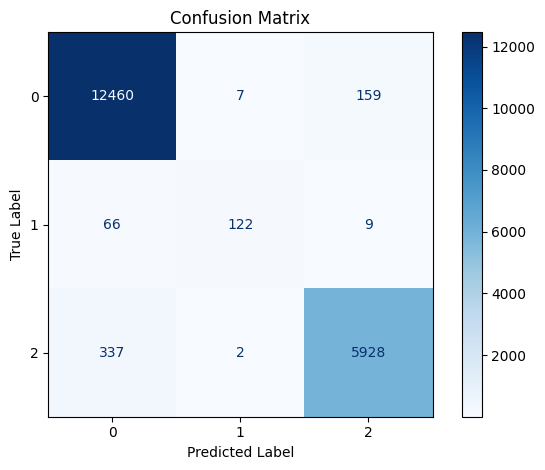

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
sensitivity, specificity = calculate_metrics_from_cm(cm)
print(sensitivity, specificity)
# Plot with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [294]:
print(allsz_lfp.shape[0], allbase_lfp.shape[0], allart_lfp.shape[0])
#fast.shape

#print(time_lfp.shape)
#trial_lfp_label = np.zeros((time_lfp.shape[0],3))
#print(trial_lfp_label.shape)

6267 12626 197


In [302]:
range(fast.shape[0])
print(fast[1,:-1].reshape(stop-start,fs).T.shape)
print(range(fast.shape[0]))
print(fast_pred.shape, duration_lfp)

(200, 180)
range(0, 169)
(169, 200, 100) 180


In [304]:
lfp_samples = duration_lfp * fs

fast_pred = np.zeros((fast.shape[0],  features_lfp, lfp_samples//features_lfp))

for in_lfp in range(fast.shape[0]):
    fast_pred[in_lfp, :, :] = fast[in_lfp,:-1].reshape(features_lfp, lfp_samples//features_lfp)


In [305]:
def get_lfplabels(lfp_3d, net, sessionID):
    net.eval()
    session = torch.tensor(lfp_3d[sessionID,:,:], device=DEVICE, dtype=torch.float32).T
    real_out = np.zeros((lfp_3d.shape[2],3))
    with torch.no_grad():
        trial_out = net(session)
        trial_label = torch.argmax(trial_out,dim=1)
        print(trial_label.cpu().numpy().shape)
        real_out[np.arange(lfp_3d.shape[2]), trial_label.cpu().numpy()] = 1

        
    return real_out

out_label = get_lfplabels(fast_pred, net,1)

(360,)


In [306]:
print(out_label.shape)

(360, 3)


In [307]:
def resample_multicolumn(t_old, data_old, fs_new, method='linear'):
    """
    Resample multi-column data to new sampling frequency
    
    Parameters:
    t_old: original time vector
    data_old: 2D array (n_samples, n_columns)  
    fs_new: new sampling frequency (Hz)
    method: interpolation method
    
    Returns:
    t_new, data_new: new time vector and resampled data
    """
    # Create new time vector
    duration = t_old[-1] - t_old[0]
    t_new = np.linspace(t_old[0], t_old[-1], int(duration * fs_new) + 1)
    
    # Interpolate all columns
    data_new = np.zeros((len(t_new), data_old.shape[1]))
    
    for col in range(data_old.shape[1]):
        f_interp = interpolate.interp1d(t_old, data_old[:, col], kind=method)
        data_new[:, col] = f_interp(t_new)
    
    return t_new, data_new


(360,)
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


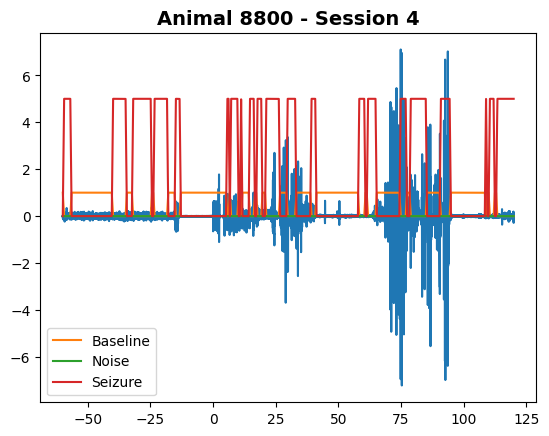

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


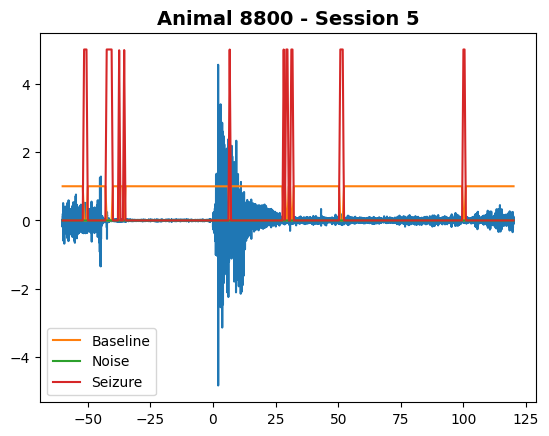

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


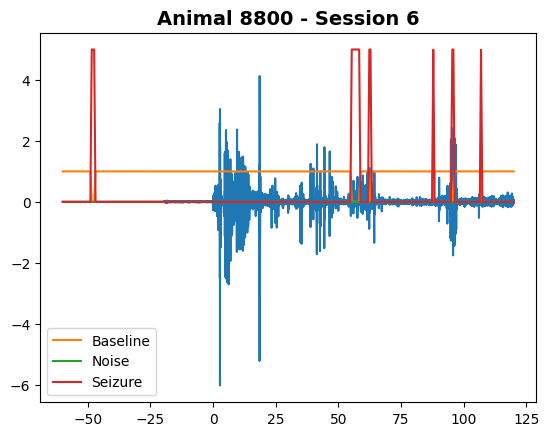

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


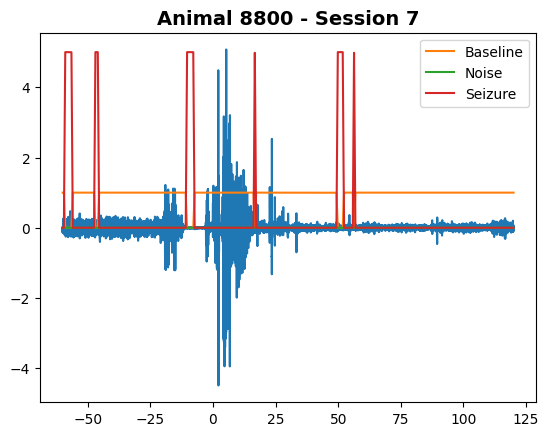

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


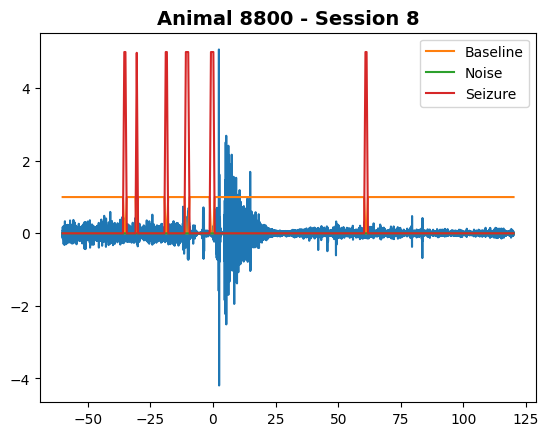

(360,)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


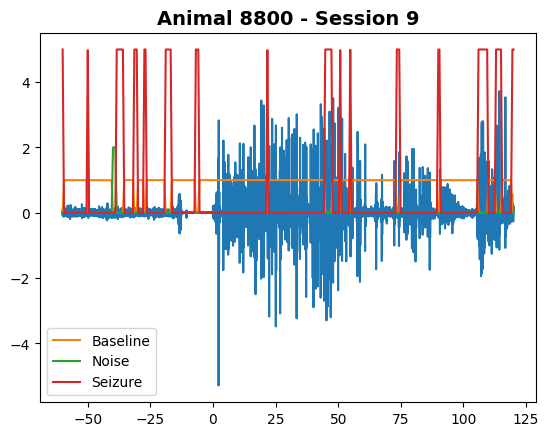

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


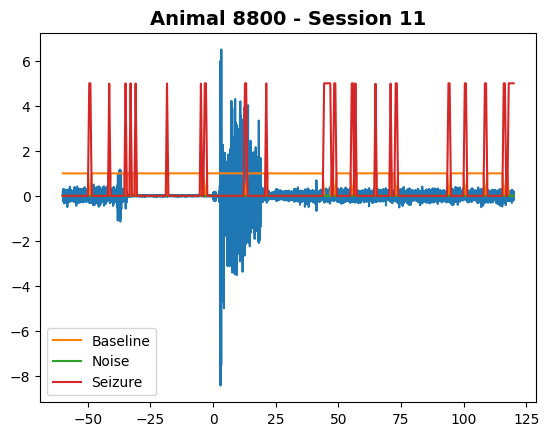

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


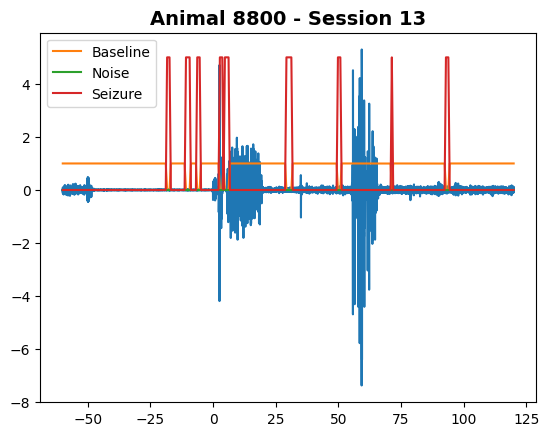

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


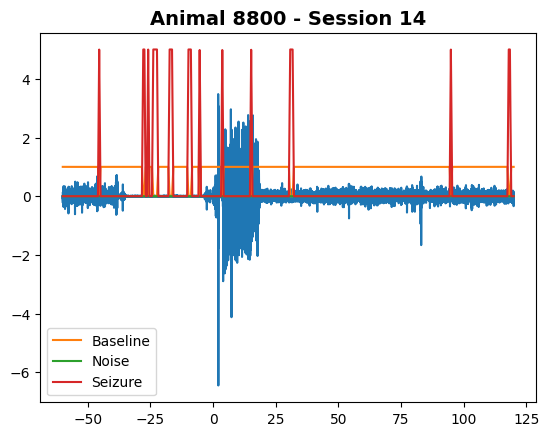

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


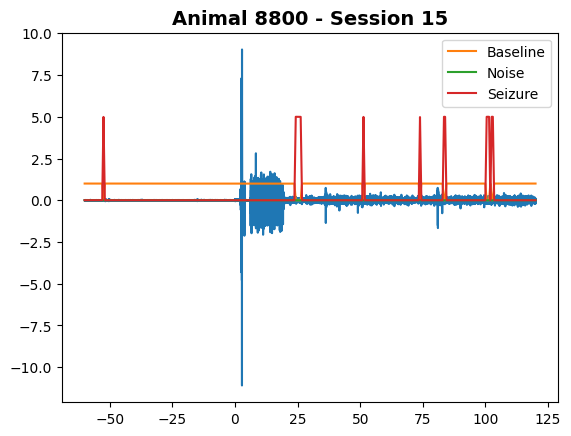

(360,)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


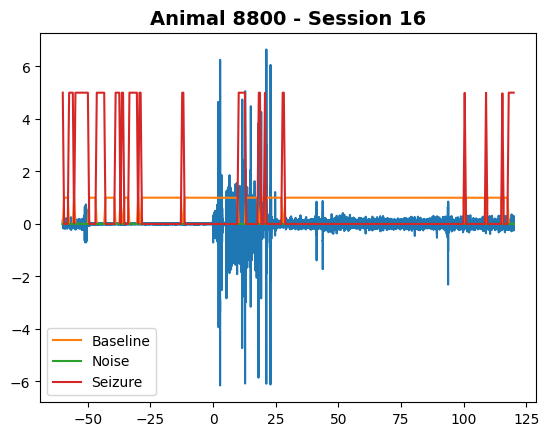

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


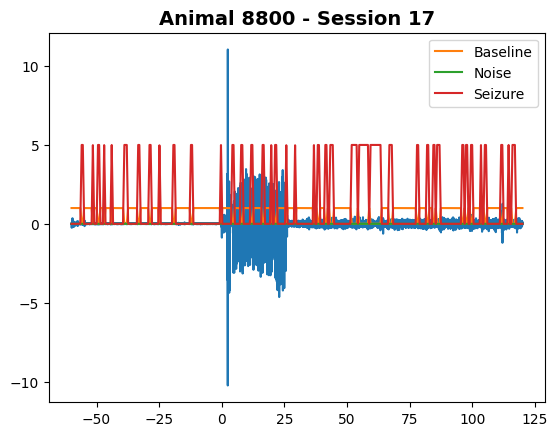

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


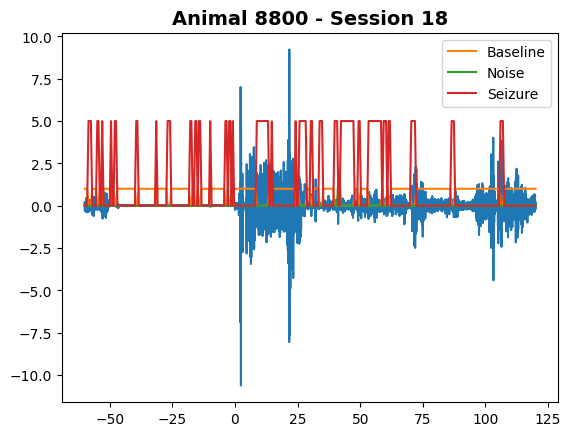

(360,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


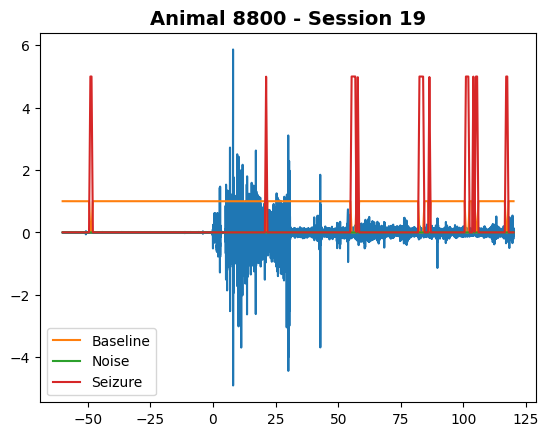

In [309]:
import os
from pathlib import Path
from scipy import interpolate
#sessiontest = [20, 21, 22, 23, 24, 31, 46, 51, 55, 89, 150, 148, 110, 112, 114, 117, 120]
animalID = 8800
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
output_dir = Path("animal_plots_Seizure")
output_dir.mkdir(exist_ok=True)
#essiontest = [117, 118, 120, 122, 123]
start = -60
stop = 120
duration_lfp = fast_pred.shape[2]
times_lfp = np.linspace(start, stop, duration_lfp)

for s_in in sessiontest:
    
    sample = torch.tensor(fast_pred[s_in,:,1], device=DEVICE, dtype=torch.float32).reshape(1, -1)
    sample.shape
    out_trial_label = get_lfplabels(fast_pred,net,s_in)
    print(out_trial_label)
    animal_label = str(int(animalID))
    session_label = str(int(metadata.Session[s_in]))
    title = f"Animal {animal_label} - Session {session_label}"
   
    #time_lfp = np.linspace(-60, 120, fast.shape[1])
    trial_lfp_label = np.zeros((time_lfp.shape[0],3))
    t_lfp, trial_lfp_label = resample_multicolumn(times_lfp, out_trial_label, fs_new=fs, method='linear')
    plt.figure()
    plt.plot(t_lfp,fast[s_in,:])
    plt.plot(t_lfp,trial_lfp_label[:,0], label=f'Baseline')
    plt.plot(t_lfp,trial_lfp_label[:,1]*2, label=f'Noise')
    plt.plot(t_lfp,trial_lfp_label[:,2]*5, label=f'Seizure')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    
    filename = f"animal_{animal_label}_session_{session_label}.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [ ]:
print(sessiontest.shape)
print(low_freq)

In [ ]:

print(metadata.Animal[117], metadata.Session[117])


In [ ]:
import sys
print(sys.prefix)